# import packages

In [1]:
# base
import numpy as np
import pandas as pd
# EDA
from ydata_profiling import ProfileReport
# preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# visualization
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
# split train & test
from sklearn.model_selection import train_test_split
# learning
from sklearn.linear_model import LogisticRegression
# metrics
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
# feature importance
import shap
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# pipeline & transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

# load dataset

In [2]:
df = pd.read_csv('D:\DRIVER\LEARNING\OUT OF UNIVERSITY\ML\dataset\Heart_health.csv')
df.sample(4)

ID                 Name  Age  Gender  Height(cm)  Weight(kg)  \
332  333            David Kim   32    Male         170          75   
536  537    Matthew Hernandez   55    Male         181          84   
336  337  Christopher Johnson   45    Male         170          75   
253  254  Elizabeth Rodriguez   43  Female         169          74   

    Blood Pressure(mmHg)  Cholesterol(mg/dL)  Glucose(mg/dL) Smoker  \
332               125/80                 210              92    Yes   
536               125/78                 220             100    Yes   
336               125/80                 210              92     No   
253               122/78                 200              88     No   

     Exercise(hours/week)  Heart Attack  
332                     4             1  
536                     3             1  
336                     4             1  
253                     2             0

# EDA

In [3]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# split data and target

In [4]:
X, Y = df.drop('Heart Attack', axis=1), df['Heart Attack']

# preprocessing

In [5]:
# encode (categorical to numerical)
X.replace({'Gender': {'Male':0, 'Female':1}}, inplace=True)
X.replace({'Smoker': {'Yes':1, 'No':0}}, inplace=True)
# Blood Pressure to sistolic and diastolic
X[['sistolic(mmHg)', 'diastolic(mmHg)']] = X['Blood Pressure(mmHg)'].str.split('/', expand=True)
# drop unusefull data
X.drop(['ID', 'Name', 'Blood Pressure(mmHg)'], inplace=True, axis=1)

In [6]:
# balance target
smote = SMOTE(random_state=42)
X_sm, Y_sm = smote.fit_resample(X, Y)

In [7]:
print('imbalenced target\n', Y.value_counts(), '\n', '-'*30)
print('balenced target\n', Y_sm.value_counts())

imbalenced target
 1    434
0    290
Name: Heart Attack, dtype: int64 
 ------------------------------
balenced target
 0    434
1    434
Name: Heart Attack, dtype: int64


In [8]:
# scaling
sc = StandardScaler()
X_sc = pd.DataFrame(sc.fit_transform(X_sm), columns=X_sm.columns)

In [9]:
df_final = pd.concat([X_sc, Y_sm], axis=1)
df_final.sample(4)

Age    Gender  Height(cm)  Weight(kg)  Cholesterol(mg/dL)  \
232  0.402148 -1.127941   -0.027669    0.068127            0.514328   
865 -0.609632  0.886571   -0.668105   -1.026947           -0.815144   
463 -0.736105  0.886571   -0.988323   -1.339825           -1.258301   
331  1.160983  0.886571    0.452659    0.693883            0.957485   

     Glucose(mg/dL)    Smoker  Exercise(hours/week)  sistolic(mmHg)  \
232        0.113606 -0.952729              1.444466        0.967962   
865       -0.743874 -0.952729              0.382826       -0.764294   
463       -0.743874 -0.952729             -0.678813       -1.259224   
331        0.971087 -0.952729             -0.678813        0.225567   

     diastolic(mmHg)  Heart Attack  
232         0.927572             1  
865        -0.325588             0  
463        -1.265458             0  
331         0.927572             1

# visualization

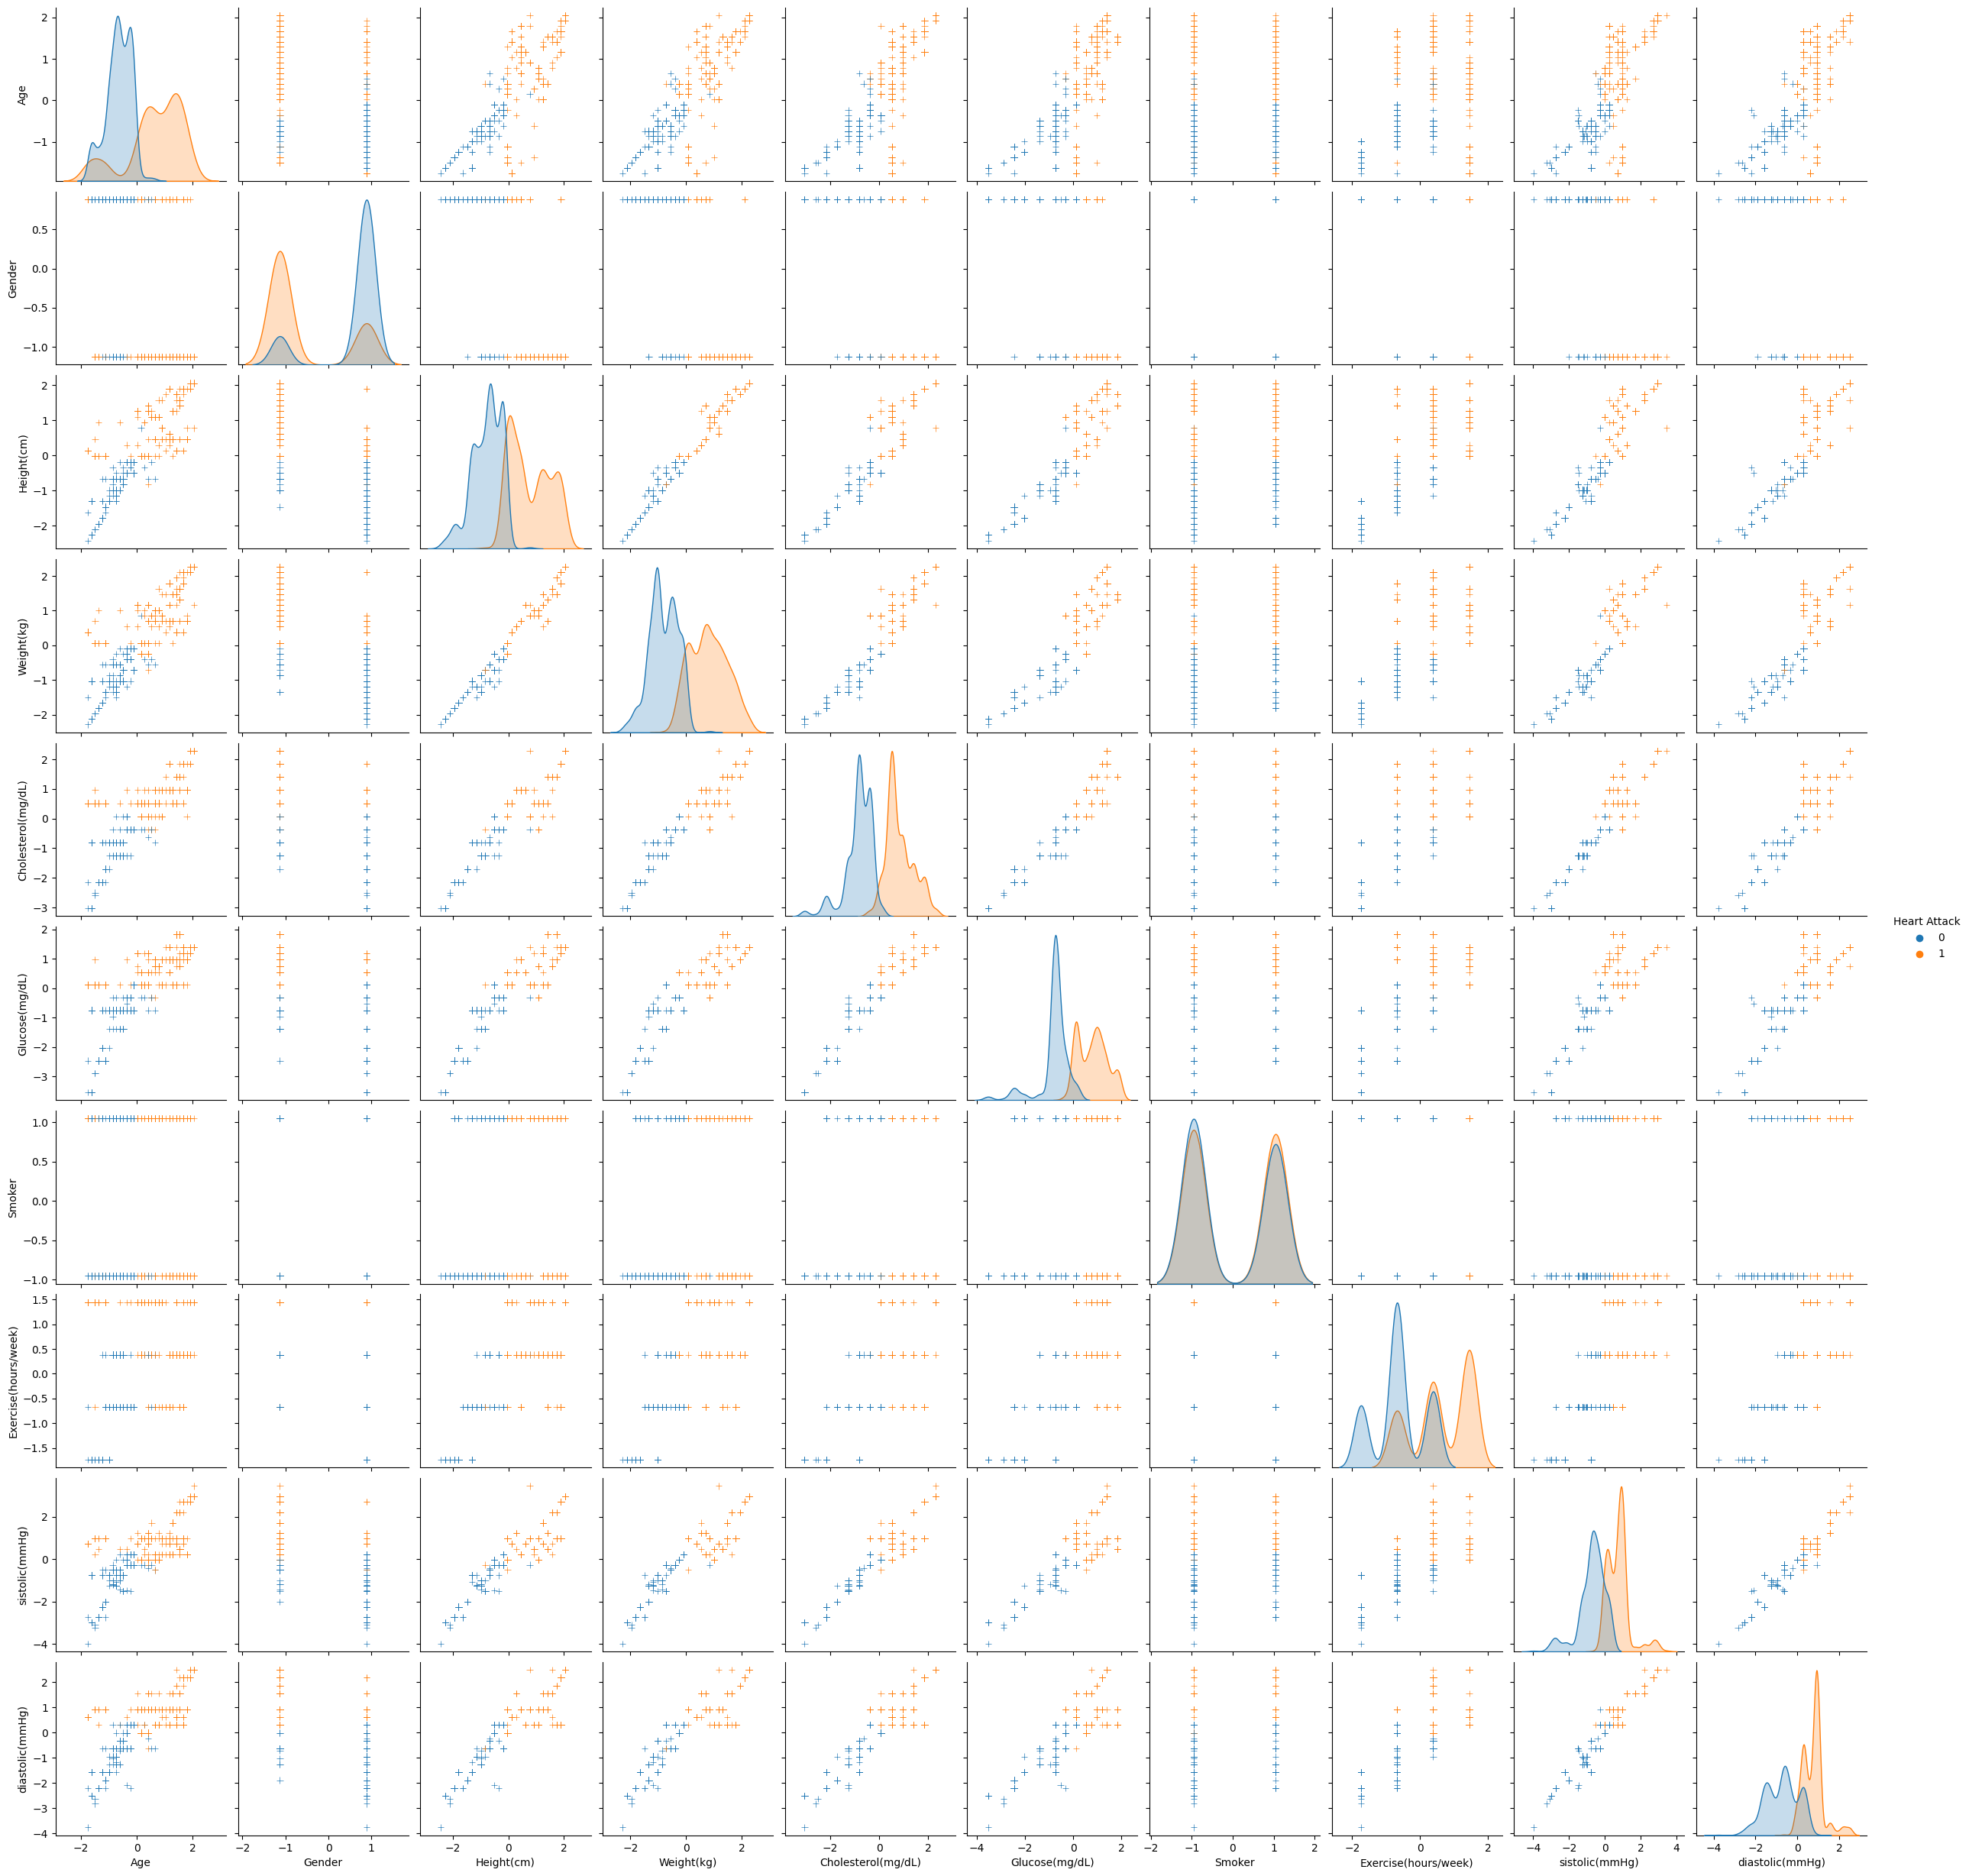

In [10]:
# plot all features
sns.pairplot(df_final, hue='Heart Attack', markers='+')
plt.show()

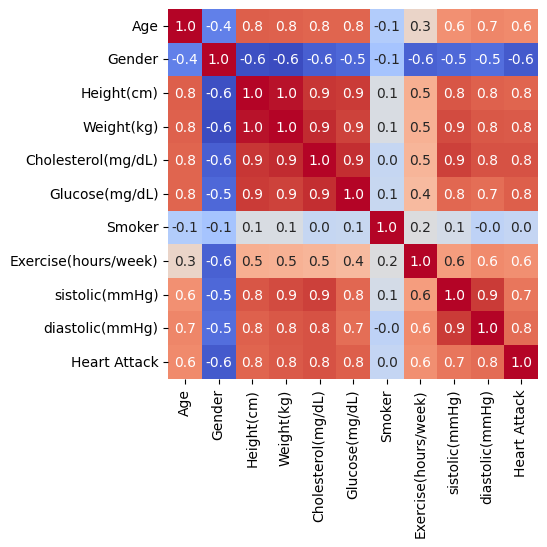

In [11]:
# correlation of all features
corr = df_final.corr()
sns.heatmap(corr, square=True, fmt='.1f', annot=True, annot_kws={'size': 10}, cmap='coolwarm', cbar=False)
plt.show()

In [12]:
# correlation of Heart Attack
corr['Heart Attack'].sort_values(ascending=False)

Heart Attack            1.000000
Cholesterol(mg/dL)      0.833932
Weight(kg)              0.811753
Glucose(mg/dL)          0.799196
Height(cm)              0.780624
diastolic(mmHg)         0.755046
sistolic(mmHg)          0.723348
Age                     0.646642
Exercise(hours/week)    0.629890
Smoker                  0.034603
Gender                 -0.589500
Name: Heart Attack, dtype: float64

# split train & test

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X_sc, Y_sm, random_state=42, test_size=0.2, stratify=Y_sm)

# learning

In [14]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

# metrics

In [15]:
prediction = lr.predict(X_test)
print(f'accuracy score:{accuracy_score(Y_test, prediction)}')
print(f'precision score:{precision_score(Y_test, prediction)}')

accuracy score:1.0
precision score:1.0


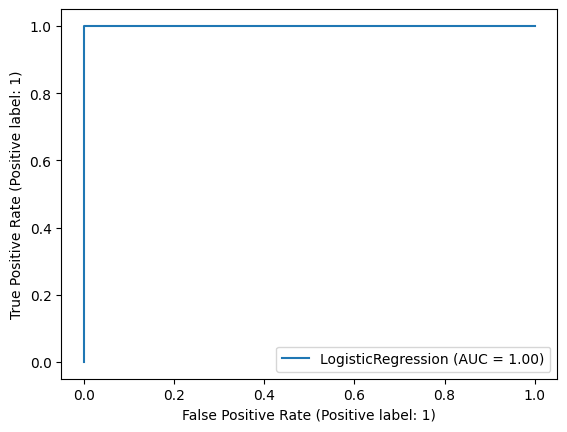

In [16]:
RocCurveDisplay.from_estimator(lr, X_test, Y_test)
plt.show()

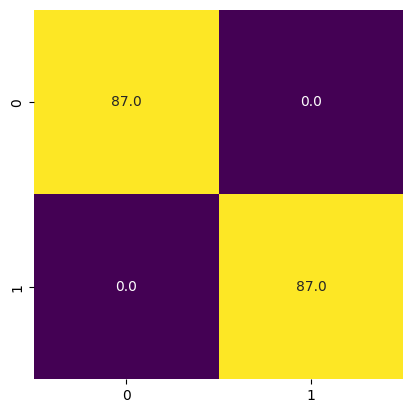

In [17]:
sns.heatmap(confusion_matrix(Y_test, prediction), square=True, fmt='.1f', annot=True, annot_kws={'size': 10}, cmap='viridis', cbar=False)
plt.show()

# feature importance

In [18]:
# using shap
explainer = shap.Explainer(lr.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 175it [00:11,  5.61it/s]                                                                     


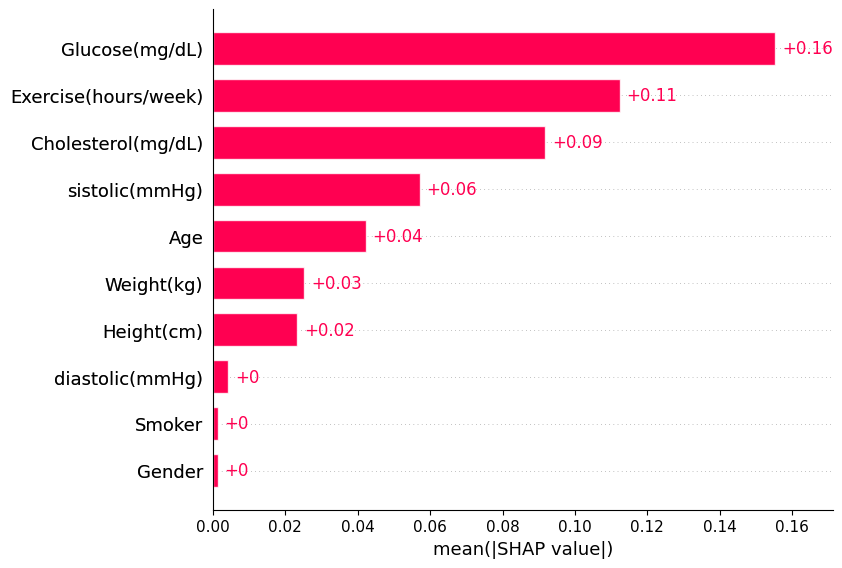

In [19]:
shap.plots.bar(shap_values)

# predict

you won't have Heart Attack


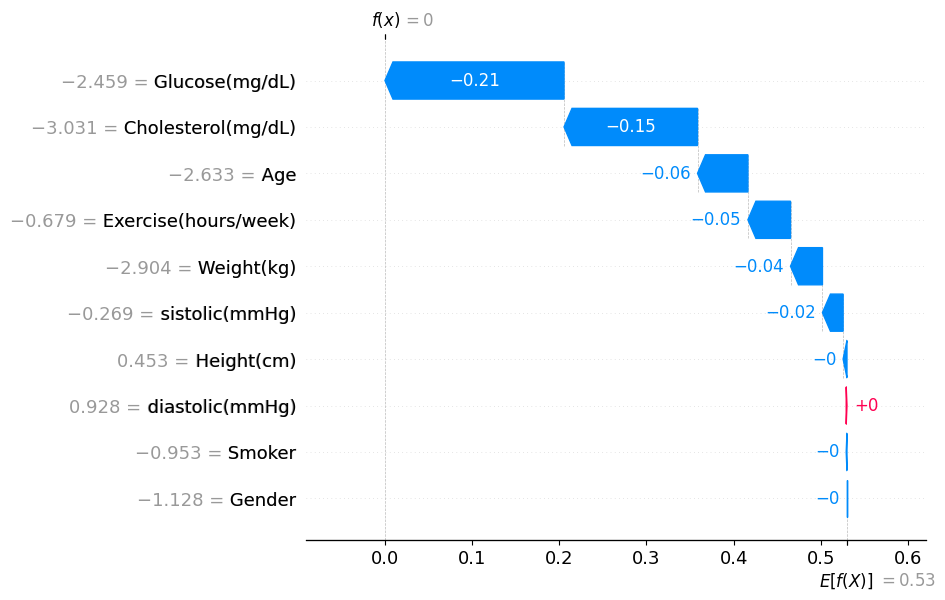

In [20]:
'''['Age', 'Gender (male: 0, female:1)', 'Height(cm)', 'Weight(kg)', 'Cholesterol(mg/dL)',
       'Glucose(mg/dL)', 'Smoker (yes:1, no:0)', 'Exercise(hours/week)', 'sistolic(mmHg)',
       'diastolic(mmHg)']'''
data = [[23, 0, 173, 56, 170, 80, 0, 2, 120, 80]]
if lr.predict(sc.transform(data))[0] == 1:
    print('you may have Heart Attack')
else:
    print("you won't have Heart Attack")
data_shap = explainer(pd.DataFrame(sc.transform(data), columns=X_train.columns))
shap.plots.waterfall(data_shap[0])